In [1]:
# Referenced from https://github.com/DL4mHealth/COMET/blob/main/data_preprocessing/PTB/PTB_preprocessing.ipynb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datautils import normalize, resample, R_Peaks, trial2sample, sample2trial

In [2]:
# specify the unziped data path and diagnostics file path
data_path = "../ECGDataDenoised"
meta_path = "../ECGDataDenoised/Diagnostics.xlsx"

In [4]:
meta = pd.read_excel(meta_path)
meta

FileName Rhythm       Beat  PatientAge  Gender  \
0      MUSE_20180113_171327_27000   AFIB   RBBB TWC          85    MALE   
1      MUSE_20180112_073319_29000     SB        TWC          59  FEMALE   
2      MUSE_20180111_165520_97000     SA       NONE          20  FEMALE   
3      MUSE_20180113_121940_44000     SB       NONE          66    MALE   
4      MUSE_20180112_122850_57000     AF  STDD STTC          73  FEMALE   
...                           ...    ...        ...         ...     ...   
10641  MUSE_20181222_204306_99000    SVT       NONE          80  FEMALE   
10642  MUSE_20181222_204309_22000    SVT       NONE          81  FEMALE   
10643  MUSE_20181222_204310_31000    SVT       NONE          39    MALE   
10644  MUSE_20181222_204312_58000    SVT       NONE          76    MALE   
10645  MUSE_20181222_204314_78000    SVT       NONE          75    MALE   

       VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  \
0                  117         234          114         356          496   
1                   52          52           92         432          401   
2                   67          67           82         382          403   
3                   53          53           96         456          427   
4                  162         162          114         252          413   
...                ...         ...          ...         ...          ...   
10641              196          73          168         284          513   
10642              162          81          162         294          482   
10643              152          92          152         340          540   
10644              175         178          128         310          529   
10645              117         104          140         312          435   

       RAxis  TAxis  QRSCount  QOnset  QOffset  TOffset  
0         81    -27        19     208      265      386  
1         76     42         8     215      261      431  
2         88     20        11     224      265      415  
3         34      3         9     219      267      447  
4         68    -40        26     228      285      354  
...      ...    ...       ...     ...      ...      ...  
10641    258    244        32     177      261      319  
10642    110    -75        27     173      254      320  
10643    250     38        25     208      284      378  
10644     98    -83        29     205      269      360  
10645    263    144        19     208      278      364  

[10646 rows x 16 columns]

In [5]:
records_name = meta["FileName"].values
len(records_name)

10646

In [6]:
meta["Rhythm"].value_counts()

Rhythm
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: count, dtype: int64

In [8]:
# group the rhythms into 4 classes
label_dict = {"SB": 0, # SB
              "AFIB": 1, "AF": 1, # AF
              "ST": 2, "SVT": 2, "AT": 2, "AVNRT": 2, "AVRT": 2, "SAAWR": 2, # GSVT
              "SR": 3, "SA": 3} # SR
labels = meta[["FileName", "Rhythm"]].replace(label_dict)
labels

/var/folders/s2/gg0gc5y53z979n2bskjqp6kc0000gn/T/ipykernel_95326/3996880336.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels = meta[["FileName", "Rhythm"]].replace(label_dict)


FileName  Rhythm
0      MUSE_20180113_171327_27000       1
1      MUSE_20180112_073319_29000       0
2      MUSE_20180111_165520_97000       3
3      MUSE_20180113_121940_44000       0
4      MUSE_20180112_122850_57000       1
...                           ...     ...
10641  MUSE_20181222_204306_99000       2
10642  MUSE_20181222_204309_22000       2
10643  MUSE_20181222_204310_31000       2
10644  MUSE_20181222_204312_58000       2
10645  MUSE_20181222_204314_78000       2

[10646 rows x 2 columns]

In [9]:
# get median R-Peak intervals for all trials, drop trials that contains nan or all zero
med_intervals = []
nan_trial = []
allzero_trial = []
abnormal_trial = []
for record in os.listdir(data_path):
    if record.endswith(".csv"):
        ecg_data = pd.read_csv(os.path.join(data_path, record), header=None).values
        if np.all(ecg_data == 0):
            allzero_trial.append(record)
            print(f"All zero: {record}")
            continue
        if np.any(np.isnan(ecg_data)):
            nan_trial.append(record)
            print(f"Nan: {record}")
            continue
        trial = []
        for ch in range(ecg_data.shape[1]):
            trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind="linear"))
        trial = np.array(trial).T
        trial_norm = normalize(trial)
        try:
            _, med, _ = R_Peaks(trial_norm)
            med_intervals.append(med.to_list())
        except IndexError:
            abnormal_trial.append(record)
            print(f"IndexError: {record}")

print(len(nan_trial), len(allzero_trial), len(abnormal_trial))
new_records_name = [r for r in records_name if r+".csv" not in nan_trial + allzero_trial + abnormal_trial]
print(len(new_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

All zero: MUSE_20181222_204236_34000.csv
All zero: MUSE_20181222_204146_34000.csv
Nan: MUSE_20180712_151357_86000.csv
Nan: MUSE_20180113_181145_89000.csv
All zero: MUSE_20181222_204239_70000.csv
All zero: MUSE_20181222_204222_63000.csv
All zero: MUSE_20181222_204132_64000.csv
All zero: MUSE_20181222_204240_84000.csv
All zero: MUSE_20181222_204310_31000.csv
Nan: MUSE_20180712_152114_47000.csv
Nan: MUSE_20180712_152014_31000.csv
Nan: MUSE_20180712_151351_36000.csv
All zero: MUSE_20181222_204227_13000.csv
Nan: MUSE_20180712_151353_58000.csv
All zero: MUSE_20181222_204219_27000.csv
All zero: MUSE_20181222_204246_47000.csv
All zero: MUSE_20181222_204140_77000.csv
Nan: MUSE_20180114_080214_06000.csv
Nan: MUSE_20180113_180425_75000.csv
All zero: MUSE_20181222_204157_58000.csv
All zero: MUSE_20181222_204212_44000.csv
All zero: MUSE_20181222_204237_47000.csv
Nan: MUSE_20180712_152024_00000.csv
All zero: MUSE_20181222_204154_20000.csv
All zero: MUSE_20181222_204143_03000.csv
All zero: MUSE_20181

0      1      2      3      4      5      6      7      8      9      ...  \
0   247.0  137.0  135.0  260.5  146.0  123.0  151.0  265.0  112.0  162.5  ...   
1   246.0  137.0  134.0  260.5  146.0  130.0  151.0  264.5  132.0  162.5  ...   
2   247.0  137.0  134.0  162.5  146.0  122.5  151.0  245.0  115.0  163.0  ...   
3   246.0  137.0  403.0  260.0  146.0  122.5  159.0  265.0  111.0  162.5  ...   
4   246.0  138.0  135.0  260.5  146.0  122.5  159.0  265.0  112.0  164.0  ...   
5   247.0  137.0  135.0  260.0  146.0  122.5  151.0  265.0  116.0  162.5  ...   
6   247.0  137.0  135.0  260.0  146.0  123.0  156.0  265.0  111.0  163.0  ...   
7   246.0  137.0  134.0  260.0  146.0  122.0  152.0  265.0  111.0  162.5  ...   
8   243.0  137.0  134.0  260.0  146.0  123.0  151.0  265.0  111.0  162.5  ...   
9   242.5  137.0  135.0  260.0  146.0  122.5  151.0  264.5  111.0  162.5  ...   
10  247.0  137.0  134.0  260.0  146.0  123.0  151.0  265.0  112.0  162.5  ...   
11  246.0  137.0  135.0  259.5  146.0  123.0  151.0  264.5  111.0  162.5  ...   

    10578  10579  10580  10581  10582  10583  10584  10585  10586  10587  
0   215.0  130.0  182.0  157.5  140.0  126.5  144.0  144.0  259.0  157.5  
1   215.0  130.0  182.0  157.5  140.0  126.5  144.0  144.0  259.0  157.0  
2   215.0  129.0  182.0  158.0  141.0  127.0  144.0  144.0  260.0  157.5  
3   216.0  130.0  181.0  157.0  155.0  126.5  144.0    NaN  259.0  157.0  
4   216.0  130.0  181.0  160.0  149.0  126.5  144.0  143.5  259.0  157.0  
5   215.0  130.0  182.0  157.5  140.0  127.0  144.0  144.0  259.0  158.0  
6   215.0  130.0  181.0  170.0  140.0  126.5  144.0  432.0  259.0  157.0  
7   215.0  130.0  182.0  158.0  139.0  127.0  144.0  144.0  259.0  158.0  
8   215.0  130.0  182.0  158.0  140.0  126.5  144.0  143.5  259.0  157.0  
9   215.0  130.0  182.0  157.5  140.0  127.0  144.0  144.0  259.0  156.5  
10  215.0  130.0  181.0  157.0  140.0  126.5  144.0  144.0  259.0  157.0  
11  216.0  130.0  182.0  157.5  140.0  126.5  144.0  144.0  259.0  157.0  

[12 rows x 10588 columns]

In [10]:
# 9713 records suitable for analysis
med_all = df_med_intervals.median()
print(med_all[med_all <= 300].shape)
print(med_all[med_all <= 300].max())
max_duration = 300

(10142,)
300.0


In [11]:
# remove records that have median interval length greater than max duration
med_intervals = []
abnormal_trial = []
med_nan_trial = []
for record in new_records_name:
    ecg_data = pd.read_csv(os.path.join(data_path, record+".csv"), header=None).values
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind="linear"))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    try:
        _, med, _ = R_Peaks(trial_norm)
        if med.median() <= max_duration:
            # if np.any(np.isnan(med)):
            #     med_nan_trial.append(record)
            #     print(f"Med Nan: {record}")
            #     continue
            med_intervals.append(med.to_list())
        else:
            abnormal_trial.append(record)
            print(f"Outlider: {record}")
    except IndexError:
        abnormal_trial.append(record)
        print(f"IndexError: {record}")
        
print(len(abnormal_trial), len(med_nan_trial))
final_records_name = [r for r in new_records_name if r not in abnormal_trial + med_nan_trial]
print(len(final_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

Outlider: MUSE_20180112_133006_47000
Outlider: MUSE_20180112_072033_34000
Outlider: MUSE_20180114_121113_24000
Outlider: MUSE_20180115_130426_87000
Outlider: MUSE_20180116_130643_35000
Outlider: MUSE_20180111_163357_09000
Outlider: MUSE_20180113_124658_83000
Outlider: MUSE_20180114_133820_34000
Outlider: MUSE_20180113_173554_96000
Outlider: MUSE_20180112_071514_26000
Outlider: MUSE_20180118_131733_19000
Outlider: MUSE_20180113_125103_10000
Outlider: MUSE_20180116_122520_49000
Outlider: MUSE_20180118_125800_75000
Outlider: MUSE_20180118_122906_36000
Outlider: MUSE_20180112_075437_85000
Outlider: MUSE_20180115_124332_88000
Outlider: MUSE_20180112_124231_23000
Outlider: MUSE_20180114_072231_70000
Outlider: MUSE_20180712_153518_42000
Outlider: MUSE_20180113_134104_50000
Outlider: MUSE_20180118_120854_33000
Outlider: MUSE_20180118_122943_50000
Outlider: MUSE_20180113_175354_59000
Outlider: MUSE_20180112_165324_19000
Outlider: MUSE_20180113_115355_59000
Outlider: MUSE_20180118_173529_22000
O

0      1      2      3      4      5      6      7      8      9      ...  \
0   133.0  287.0  223.5  282.5   92.0  266.5  156.0  238.5  259.0  257.5  ...   
1   132.5  288.0  224.0  283.0   92.0  266.5  155.0  238.0  260.0  257.5  ...   
2   132.5  287.0  224.5  283.0   92.0  266.5  157.0  238.0  259.0  256.0  ...   
3   133.0  296.0  223.5  283.5   92.0  264.0  172.0  238.0  259.0  257.5  ...   
4   131.5  287.0  224.0  282.5   92.0  266.0  157.0  238.0  259.0  257.0  ...   
5   132.5  287.0  224.0  280.0   92.0  266.5  155.0  238.0  260.0  257.0  ...   
6   132.5  287.0  225.5  283.0   92.0  266.0  158.0  238.5  259.0  257.5  ...   
7   133.0  287.0  225.5  283.0   92.0  266.5  156.0  238.5  260.0  256.0  ...   
8   132.0  288.0  224.5  282.5   92.0  266.5  157.0  238.0  259.0  256.0  ...   
9   133.0  287.0  223.5  282.5   92.0  266.5  156.0  238.5  259.0  257.5  ...   
10  133.0  287.0  224.0  282.5   92.0  266.5  156.0  238.5  259.0  257.5  ...   
11  131.5  287.0  223.5  282.5   92.0  266.5  156.0  238.5  259.0  257.0  ...   

    10132  10133  10134  10135  10136  10137  10138  10139  10140  10141  
0    86.0   93.5   99.0   88.0   87.0   78.0   86.0  148.5  107.0  100.0  
1    86.0   93.5   99.0   88.0   87.0   78.0   86.0  149.0  106.0  101.0  
2    86.0   93.0   99.0   88.0   87.0   78.0   86.0  224.0  107.0  100.0  
3    86.0   93.0   99.0   88.0   87.0   79.0   86.0  149.0  107.0    NaN  
4    86.0   93.0   99.0   89.0   87.0   78.0   86.0  148.5  107.0  100.0  
5    86.0   93.5   99.0   88.0   87.0   78.0   86.0  149.0  106.0  100.0  
6    86.0   93.5   99.0   88.0   87.0   78.0    NaN  149.0  107.0  100.0  
7    86.0   93.5   99.0   88.0   87.0   78.0   85.0  149.0  107.0  100.0  
8    86.0   93.0   99.0   89.0   87.0   78.0   86.0  149.0  107.0  100.0  
9    86.0   93.5   99.0   88.0   87.0   78.0   85.0  149.0  107.0  100.0  
10   86.0   93.0   99.0   88.0   87.0   78.0   85.0  149.0  106.5  100.0  
11   86.0   93.5   99.0   88.0   87.0   78.0   86.0  149.0  106.0  101.0  

[12 rows x 10142 columns]

In [12]:
# main
feature_path = "../dataset/chapman/feature"
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
    
dict_label = {}
sub_id = 1
for record in final_records_name:
    label = labels[labels["FileName"]==record]["Rhythm"].values[0]
    dict_label[sub_id] = label
    ecg_data = pd.read_csv(os.path.join(data_path, record+".csv"), header=None).values
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind="linear"))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    samples = trial2sample(trial_norm, max_duration=300) # segment and pad
    segmentations = sample2trial(samples, size=6) # regroup
    
    if segmentations != list():
        segmentations = np.array(segmentations)
        print(segmentations.shape)
        np.save(os.path.join(feature_path, f"feature_{sub_id:05d}"), segmentations)
        sub_id += 1    
    else:
        print(f"The subject is None after preprocessing: {record}")  

(3, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(4, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(4, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 18

In [13]:
len(dict_label)

10142

In [14]:
label_path = "../dataset/chapman/label"
if not os.path.exists(label_path):
    os.makedirs(label_path)

df_label = pd.DataFrame([dict_label]).T
df_label = df_label.reset_index().astype("int64")
labels = df_label[[0, "index"]].values
np.save(os.path.join(label_path, "label"), labels)

In [15]:
# test
sig = np.load("../dataset/chapman/feature/feature_01000.npy")
sig

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(2, 1800, 12))

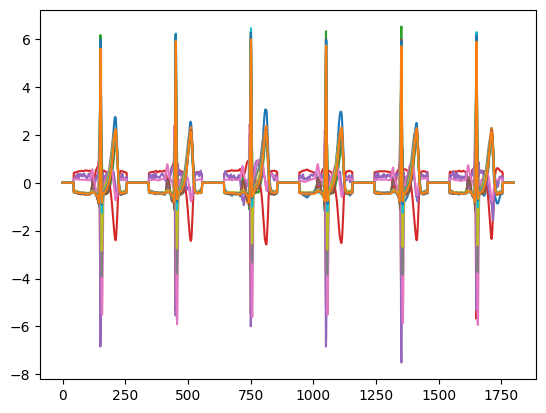

In [16]:
plt.plot(sig[0])

In [18]:
labs = np.load("../dataset/chapman/label/label.npy")
labs

array([[    1,     1],
       [    0,     2],
       [    3,     3],
       ...,
       [    2, 10140],
       [    2, 10141],
       [    2, 10142]], shape=(10142, 2))